# Radioactive decay ☢️

In [1]:
import festim as F
import numpy as np
import sympy as sp

my_model = F.Simulation()

vertices = np.concatenate(
    [
        np.linspace(0, 2e-5, num=1000),
        np.linspace(2e-5, 1e-4, num=300),
        np.linspace(1e-4, 1e-2, num=100),
    ]
)
my_model.mesh = F.MeshFromVertices(vertices)

my_model.materials = F.Material(id=1, D_0=1e-7, E_D=0.2)

my_model.traps = F.Trap(
    k_0=1e-16,
    E_k=0.2,
    p_0=1e13,
    E_p=1.2,
    density=1.3e24,
    materials=my_model.materials[0],
)

exposure_time = 2e7
my_model.boundary_conditions = [
    F.DirichletBC(
        surfaces=[1],
        value=sp.Piecewise((1e17, F.t < exposure_time), (0, True)),
        field="solute",
    )
]

my_model.dt = F.Stepsize(
    initial_value=1e3, stepsize_change_ratio=1.1, milestones=[exposure_time]
)

my_model.T = F.Temperature(300)

In [2]:
half_life = 12 * 365 * 24 * 3600  # 12 years
decay_constant = np.log(2) / half_life

my_model.sources = [
    F.RadioactiveDecay(decay_constant=decay_constant, volume=1, field="all"),
]

In [3]:
derived_quantities = F.DerivedQuantities(
    [
        F.TotalVolume("retention", volume=1),
        F.TotalVolume("solute", volume=1),
        F.TotalVolume("1", volume=1),
    ]
)
txt_export = F.TXTExport(
    "retention",
    times=[
        exposure_time,
        exposure_time + 1 * half_life,
        exposure_time + 2 * half_life,
    ],
    filename="task11/profiles.txt",
)

my_model.exports = [derived_quantities, txt_export]

In [4]:
my_model.settings = F.Settings(
    absolute_tolerance=1e6,
    relative_tolerance=1e-10,
    final_time=exposure_time + 2 * half_life,
    traps_element_type="DG",
)

my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:49: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(
/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/festim/generic_simulation.py:334: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)


100.0 %        7.8e+08 s    Ellapsed time so far: 7.2 s


/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Text(0, 0.5, 'Inventory [T/m$^{2}$]')

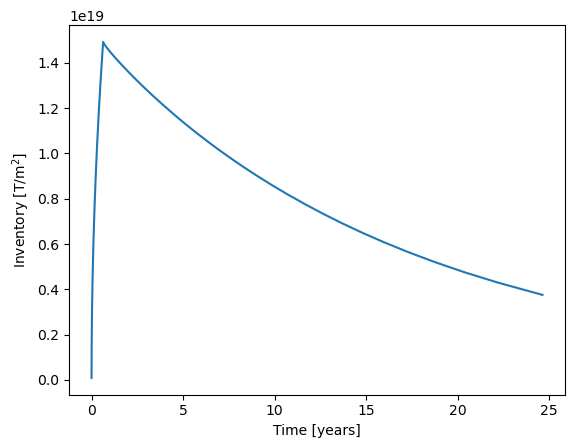

In [5]:
import matplotlib.pyplot as plt

time = np.array(derived_quantities[0].t)
retention = derived_quantities[0].data

solute = derived_quantities[1].data
trapped = derived_quantities[2].data
one_year = 365 * 24 * 3600
plt.plot(time / one_year, retention)
plt.xlabel("Time [years]")
plt.ylabel("Inventory [T/m$^{2}$]")

Text(0, 0.5, 'Retention [T m$^{-3}$]')

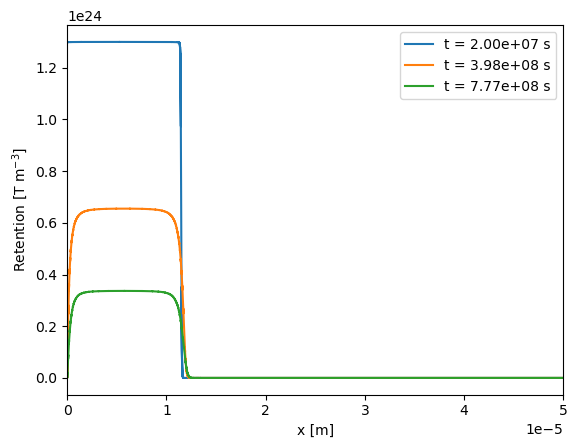

In [6]:
data = np.genfromtxt("task11/profiles.txt", delimiter=",", names=True)

for time in my_model.exports[1].times:
    name = f"t={time:.2e}s"
    name_clean = name.translate(str.maketrans("", "", "+.="))
    plt.plot(data["x"], data[name_clean], label=f"t = {time:.2e} s")

plt.legend()
plt.xlim(0, 5e-5)
plt.xlabel("x [m]")
plt.ylabel("Retention [T m$^{-3}$]")